In [1]:
import datetime

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from elarb import datasets, util

In [2]:
N_SOLAR = 100
N_INVERTERS = 3
N_BATTERY = 9
#STIKLEDNING_KWH = 12.8
STIKLEDNING_A = 63
STIKLEDNING_V = 400
STIKLEDNING_KWH = STIKLEDNING_A*STIKLEDNING_V / 1000


In [12]:
STIKLEDNING_KWH

25.2

## Load data

### Nordpool

In [3]:
#df = datasets.download_nordpool('2022-10-09', '2022-10-11')
#df = df[df.HourDK >= '2022-10-09 12:00:00'].reset_index()
#df.to_csv('../data/example.csv', index=False)
df = pd.read_csv('../data/example.csv', parse_dates=['HourUTC', 'HourDK', 'dt'])
spot_dkk = df.SpotPriceDKK.values / 1000.0
df.head(3)

,index,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR,dt,h
0,12,2022-10-09 10:00:00,2022-10-09 12:00:00,DK2,446.040009,59.970001,2022-10-09,12
1,13,2022-10-09 11:00:00,2022-10-09 13:00:00,DK2,371.890015,50.000000,2022-10-09,13
2,14,2022-10-09 12:00:00,2022-10-09 14:00:00,DK2,407.220001,54.750000,2022-10-09,14


In [4]:
ts0 = df.HourDK.min()
ts1 = df.HourDK.max()
print(ts0, ts1)

2022-10-09 12:00:00 2022-10-10 23:00:00


### PV Watts

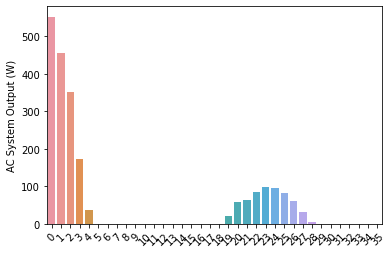

In [5]:
df_pv = pd.read_csv('../data/pvwatts.csv')

idx0 = df_pv[(df_pv.Month == ts0.month) & (df_pv.Day == ts0.day) & (df_pv.Hour == ts0.hour)].index[0]
idx1 = df_pv[(df_pv.Month == ts1.month) & (df_pv.Day == ts1.day) & (df_pv.Hour == ts1.hour)].index[0]+1
df_pv_win = df_pv[idx0:idx1].reset_index().copy()
sns.barplot(x=df_pv_win.index, y=df_pv_win['AC System Output (W)'])
plt.xticks(rotation=45)
plt.show()

## Optimal policy

```
           ┌───────┐       
    ┌─x1──▶│ Grid  │──┐    
    │      └───────┘  │    
┌───────┐      ▲      │    
│ Solar │      │x3    │x4    
└───────┘      │      │    
    │      ┌───────┐  │    
    └─x2──▶│Battery│◀─┘    
           └───────┘       
```

### Parameters

In [13]:
n = len(spot_dkk)

# 1 inverter: Deye SUN-12K-SG04LP3-EU
inverter_cap_single = 12
inverter_cap = N_INVERTERS * inverter_cap_single

# grid
d_grid = cp.Parameter(n, nonneg=True)
d_grid.value = np.zeros(n) + STIKLEDNING_KWH
s_grid = cp.Parameter(n, nonneg=True)
s_grid.value = np.zeros(n) + STIKLEDNING_KWH

# battery: Powerwall LBATTS Powerwall, 8.8 kwh
bat_cap_single = 8.8
bat_cap = N_BATTERY * bat_cap_single
bat_discharge = N_BATTERY * 11.52
bat_cost_dkk = 21000
bat_cycles = 6000
bat_depreciation = bat_cost_dkk / (bat_cap_single*bat_cycles)
bat_loss = 0.03
bat_SoC = ... # defined later

# solar panels: 470Wp JinKO TigerNeo N-Type 60HL4 BF, 1.57 kWh / time
solar_panelcost = 1565
solar_years = 30
solar_depreciation = solar_panelcost / (24*365*solar_years)
s_solar = N_SOLAR * df_pv_win['AC System Output (W)'].values * 60 * 60 / 1000

# prices
p_x1 = cp.Parameter(n)
p_x1.value = np.zeros(n) + spot_dkk - solar_depreciation 

p_x2 = cp.Parameter(n)
p_x2.value = np.zeros(n) - solar_depreciation # - bat_depreciation

p_x3 = cp.Parameter(n)
p_x3.value = np.zeros(n) + spot_dkk - bat_depreciation

p_x4 = cp.Parameter(n)
p_x4.value = np.zeros(n) - spot_dkk # - bat_depreciation

In [16]:
s_solar

array([198900., 164412., 126180.,  62208.,  13608.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,   7416.,  20880.,
        23220.,  30924.,  35136.,  34740.,  29844.,  21492.,  11376.,
         1980.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.])

In [7]:
bat_depreciation

0.39772727272727265

### Variables

In [8]:
x1 = cp.Variable(n, nonneg=True)
x2 = cp.Variable(n, nonneg=True)
x3 = cp.Variable(n, nonneg=True)
x4 = cp.Variable(n, nonneg=True)

### Objective function

In [9]:
contrib_x1 = p_x1@x1
contrib_x2 = p_x2@x2
contrib_x3 = p_x3@x3
contrib_x4 = p_x4@x4
objective = cp.Maximize(cp.sum(contrib_x1 + contrib_x2 + contrib_x3 + contrib_x4))

### Constraints

```
           ┌───────┐       
    ┌─x1──▶│ Grid  │──┐    
    │      └───────┘  │    
┌───────┐      ▲      │    
│ Solar │      │x3    │x4    
└───────┘      │      │    
    │      ┌───────┐  │    
    └─x2──▶│Battery│◀─┘    
           └───────┘       
```

In [10]:
# TODO: plug in battery loss somewhere... in bat_SoC
charge_loss = 0.97
bat_soc = cp.cumsum(x2*charge_loss + x4*charge_loss - x3)
d_bat = bat_cap - bat_soc

constraints = [
    # sales to grid cannot exceed demand of grid
    x1 + x3 <= d_grid,
    # sales to bat cannot exceed demand (i.e. gap to full) of battery
    x2 + x4 <= d_bat,
    # buys from solar cannot exceed supply of solar
    x1 + x2 <= s_solar,
    # sells from battery cannot exceed maximum discharge
    x3 <= bat_discharge,
    # sells from battery cannot exceed state of charge (SoC)  
    x3 <= bat_soc,
    # buys from grid cannot exceed supply of grid
    x4 <= s_grid,
    # SoC cannot exceed battery capacity, i.e. the max over cumulative sum of battery flow cannot exceed capacity 
    cp.max(bat_soc) <= bat_cap,
    # x1 + x2 + x3 + x4 cannot exceed inverters
    x1 + x2 + x3 + x4 <= inverter_cap,
]

### Solve problem

Stikledning ampere = 63 A
Solar only = 387.06 DKK
Solar + arbitrage = 564.19 DKK
- Solar to grid (x1) = 376.95 DKK
- Solar to battery (x2) = -0.78 DKK
- Battery to grid (x3) = 191.51 DKK
- Grid to battery (x4) = -3.48 DKK
- Check:  564.2 DKK
Arbitrage lift (percent) = 45.76%




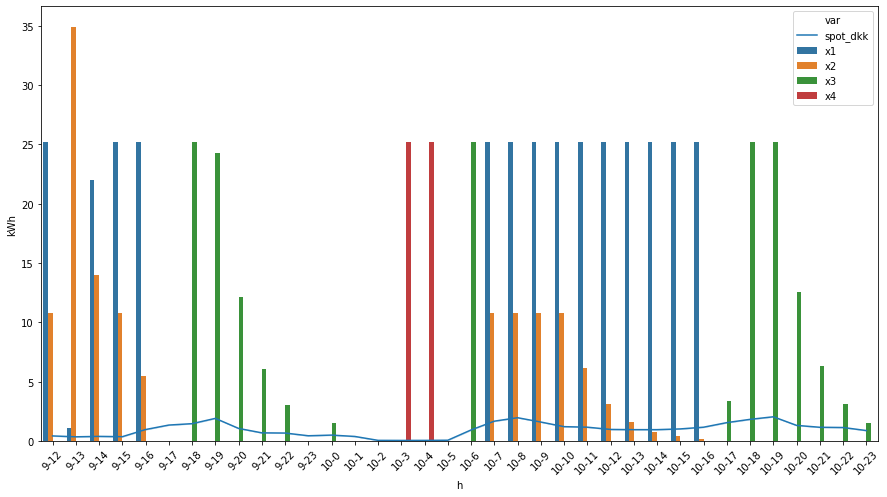

In [11]:
prob = cp.Problem(objective, constraints)
result = prob.solve()
s_solar_clipped = np.clip(s_solar, 0, d_grid.value)
result_solaronly = np.round((s_solar_clipped@p_x1).value, 2)
result_solar_and_arb = np.round(result, 2)

x1_component = cp.sum(x1@p_x1).value.round(2)
x2_component = cp.sum(x2@p_x2).value.round(2)
x3_component = cp.sum(x3@p_x3).value.round(2)
x4_component = cp.sum(x4@p_x4).value.round(2)

print('Stikledning ampere =', STIKLEDNING_A, 'A')
print('Solar only =', result_solaronly, 'DKK')
print('Solar + arbitrage =', result_solar_and_arb, 'DKK')
print('- Solar to grid (x1) =', x1_component, 'DKK')
print('- Solar to battery (x2) =', x2_component, 'DKK')
print('- Battery to grid (x3) =', x3_component, 'DKK')
print('- Grid to battery (x4) =', x4_component, 'DKK')
print('- Check: ', np.round(x1_component + x2_component + x3_component + x4_component, 2), 'DKK')
arb_lift = np.round(100*((result_solar_and_arb / result_solaronly) - 1), 2)
print(f'Arbitrage lift (percent) = {arb_lift}%')
print()
#hours_per_year = 365*24
#yearly_revenue = np.round(hours_per_year*result_solar_and_arb/len(spot_dkk), 2)
#print(f'Extrapolated yearly revenue (after depreciation) = {yearly_revenue} DKK')

#print('Solar to grid:', x1.value.round(3), 'maximum:', max(x1.value.round(3)))
#print('Solar to battery:', x2.value.round(3), 'maximum:', max(x2.value.round(3)))
#print('Battery to grid:', x3.value.round(3), 'maximum:', max(x3.value.round(3)))
#print('Grid to battery:', x4.value.round(3), 'maximum:', max(x4.value.round(3)))
#print(np.round(constraints[0].dual_value, 2))
print()

dts = [pd.to_datetime(d) for d in df.HourDK]
h = [f'{d.day}-{d.hour}' for d in dts]
hs = np.tile(h, 4)
h = np.tile(np.arange(n), 4)
p = spot_dkk
ps = np.tile(p, 4)
df_plot = pd.DataFrame({
    'h': hs,
    'spot_dkk': ps,
    'kWh': (
        x1.value.tolist()
        +x2.value.tolist()
        +x3.value.tolist()
        +x4.value.tolist()),
    'var': (
        ['x1']*n
        + ['x2']*n
        + ['x3']*n
        + ['x4']*n
    )
})
plt.figure(figsize=(15,8))
sns.lineplot(data=df_plot, x='h', y='spot_dkk', label='spot_dkk')
sns.barplot(data=df_plot, x='h', y='kWh', hue='var')
plt.xticks(rotation=45)
plt.show()